In [1]:
!pip install transformers

In [2]:
!pip install datasets jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.5 MB/s eta 0:00:00


In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
with open('../input/indic-handwritten-text-malayalam/vocab.txt') as f:
    vocab = f.readlines()
print(vocab[0])

അംഗ



In [5]:
with open('../input/indic-handwritten-text-malayalam/train.txt') as f:
    train = f.readlines()


train_list = []
for i in range(len(train)):
    image_id = train[i].split(",")[0].split('/')[1].strip()
    vocab_id = int(train[i].split(",")[1].strip())
    text = vocab[vocab_id].split('\n')[0]
    row = [image_id, text]
    train_list.append(row)

train_df = pd.DataFrame(train_list, columns=['file_name', 'text'])
train_df.head()

,file_name,text
0,1.jpg,ഇരുന്ന
1,2.jpg,പ്രത്യേകിച്ചും
2,3.jpg,ഖനന
3,4.jpg,ഫ്രണ്ടിനെതിരെ
4,5.jpg,സുഗതകുമാരിയുടെ


In [6]:
with open('../input/indic-handwritten-text-malayalam/test.txt') as f:
    test = f.readlines()


test_list = []
for i in range(len(test)):
    image_id = test[i].split(",")[0].split('/')[1].strip()
    vocab_id = int(test[i].split(",")[1].strip())
    text = vocab[vocab_id].split('\n')[0]
    row = [image_id, text]
    test_list.append(row)

test_df = pd.DataFrame(test_list, columns=['file_name', 'text'])
test_df.head()

,file_name,text
0,1.jpg,വിശ്വാസങ്ങളുടെയും
1,2.jpg,കൈക്കൂലിയും
2,3.jpg,വീണ്ടുവിചാരമാണ്
3,4.jpg,കോടതിക്ക്
4,5.jpg,പോകുന്നില്ല


In [7]:
with open('../input/indic-handwritten-text-malayalam/val.txt') as f:
    val = f.readlines()


val_list = []
for i in range(len(val)):
    image_id = val[i].split(",")[0].split('/')[1].strip()
    vocab_id = int(val[i].split(",")[1].strip())
    text = vocab[vocab_id].split('\n')[0]
    row = [image_id, text]
    val_list.append(row)

val_df = pd.DataFrame(val_list, columns=['file_name', 'text'])
val_df.head()

,file_name,text
0,1.jpg,പ്രോത്സാഹിപ്പിക്കാറുണ്ട്
1,2.jpg,ബ്രഹ്മ
2,3.jpg,തോന്നി
3,4.jpg,അനുവദിക്കാനുള്ള
4,5.jpg,തൊടുത്തു


In [8]:
print(train_df.shape, test_df.shape, val_df.shape)

(85270, 2) (19635, 2) (11878, 2)


In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [10]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='../input/indic-handwritten-text-malayalam/train/train/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='../input/indic-handwritten-text-malayalam/test/test/',
                           df=test_df,
                           processor=processor)

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [11]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 85270
Number of validation examples: 19635


In [12]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


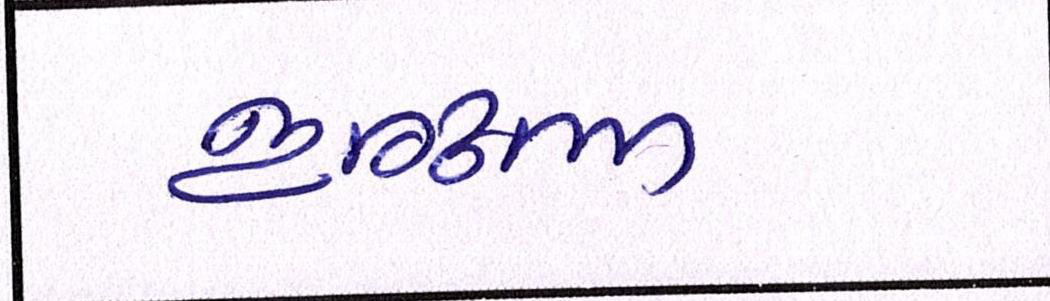

In [13]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [14]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

ഇരുന്ന


In [15]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/4.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [17]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir="./",
    logging_steps=2,
    save_steps=400,
    eval_steps=200,
)

In [18]:
from datasets import load_metric
cer_metric = load_metric("cer")

In [19]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [20]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 85270
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31977
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-pack

Exception: problem